# GraphCut

## Лабораторная работа № 1

### Выполнила: Егорова Вера

In [67]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

Граф представляет собой сеточную модель, узлы сетки соответсвуют пикселам изображения. Кроме того, в графе вводятся две дополнительные вершины: исток и сток, которые соединены со всеми узлами сетки. Узлам модели соответсвуют бинарные переменные $\mathbf{y} \in \{0,1\}^{|\nu|}$. Истоку соответствует переменная $s=1$, стоку - переменная $t=0$<br>
Запишем функционал энергии в общем виде:<br>
$$E(\mathbf{y})=\sum_{p\in\nu}E_p(y_p)+\sum_{p,q\in N}E_{pq}(y_{pq})$$
$E_p(y_p)$ - унарные потенциалы, зависят от метки изображения <br>
$E_{pq}(y_{pa})$ - бинарные потенциалы - штрафы за сходство или различие соседних переменных в зависимости от свойств изображения. <br>
Реализация энергии для нашего графа: <br>
$$E(\mathbf{y})=\sum_{p\in\nu}F^p(y_p)+\sum_{p\in\nu}B^p(1-y_p)+\sum_{p,q\in N}P^{pq}(|y_p-y_q|)$$
$F^p \ge0, B^p\ge0, P^{pq}\ge0$ <br>
$F^p$ - метка ребра, связанного со стоком <br>
$B^p$ - метка ребра, связанного с истоком <br>
$P^{pq}$ - метка ребра, связывающего соседние вершины <br>
Если ребра, соединяющие вершины сетки с истоком, попадают в минимальный разрез, то соответствующие вершины получают метку 0. Аналогично, если ребра, соединяющие вершины со стоком, попадают в минимальный разрез, то соответствующие вершины получают метку 1.<br>
Таким образом, минимум функции $E(\mathbf{y})$ соответствует минимальному разрезу такой сети.

### cv2.grabCut()

Рассмотрим аргументы функции cv2.grabCut(): <br>
<li> img - исходное изображение
<li> mask - маска, которая определяет, какие области изображения относятся к фону, а какие - к объекту (задается посредством флагов: cv2.GC_BGD - пиксели фона, cv2.GC_FGD - пиксели объекта, cv2.GC_PR_BGD -  пиксели, котороые возможно относятся к фону, cv2.GC_PR_FGD - пиксели, которые возможно относятся к объекту)
<li> rect - координаты прямоугодльника, содержащего в себе объект. Пикселы вне прямоугольника считаются по умолчанию фоном.
<li> bdgModel, fgdModel - временные массивы, которые используются только внутри функции
<li> iterCount - число итераций алгоритма
<li> mode - может принимать значения cv2.GC_INIT_WITH_RECT или cv2.GC_INIT_WITH_MASK или их комбинацию, которая задает, что мы получим в результате: прямоугольник с объектом или его точную границу.

### Утенок 

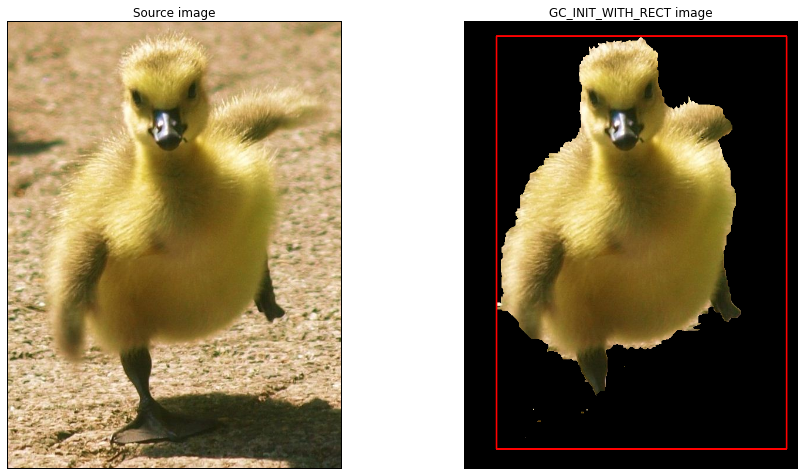

In [68]:
def grab_cut_with_rect(source_image, pnt1, pnt2):
    height, width, channels = source_image.shape
    mask = np.zeros((height, width), np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    result_image = np.array(source_image)
    rect = (pnt1[0], pnt1[1], pnt2[0]-pnt1[0], pnt2[1]-pnt1[1])

    cv2.grabCut(result_image, mask, rect, bgdModel, fgdModel, 
                10, cv2.GC_INIT_WITH_RECT)

    for i in xrange(height):
        for j in xrange(width):
            if mask[i][j] == cv2.GC_BGD or mask[i][j] == cv2.GC_PR_BGD:
                result_image[i][j] = (0, 0, 0)

    cv2.rectangle(result_image, pnt1, pnt2, color=(0, 0, 255), thickness=2)

    fig = plt.figure(figsize=(15, 8)) 
    plt.subplot2grid((1,2), (0,0), colspan=1)
    plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
    plt.title('Source image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot2grid((1,2), (0,1), colspan=1)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title('GC_INIT_WITH_RECT image')
    plt.xticks([])
    plt.yticks([])
    plt.show()


grab_cut_with_rect(source_image, (55, 27), (550, 730))

Видим, что при сегментации потерялась одна лапка и часть верхнего крыла. Видимо, потому что они сильно сливаются с фоном. Попробуем это исправить при генерации маски для сегментации GC_INIT_WITH_MASK.

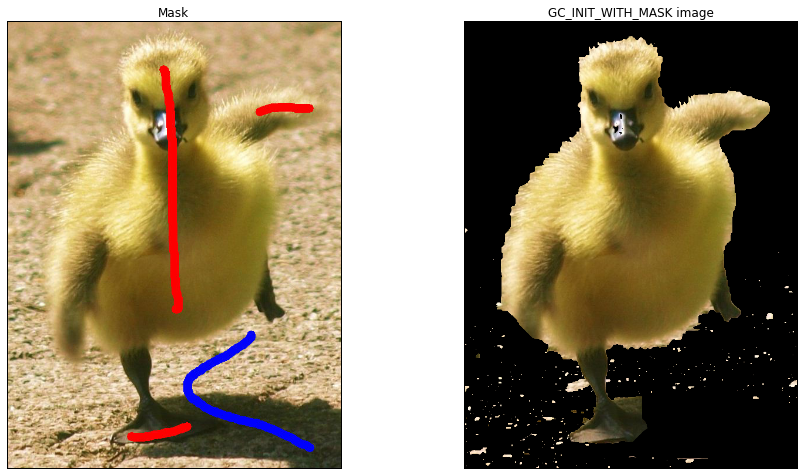

In [69]:
def grab_cut_with_image(image_mask):
    height, width, channels = source_image.shape
    mask = np.zeros((height, width), np.uint8)
    for i in xrange(height):
        for j in xrange(width):
            if image_mask[i][j][2] == 255:
                mask[i][j] = cv2.GC_FGD
            elif image_mask[i][j][0] == 255:
                mask[i][j] = cv2.GC_BGD
            else:
                mask[i][j] = cv2.GC_PR_BGD
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    image = np.array(source_image)

    cv2.grabCut(image, mask, None, bgdModel, fgdModel, 
                5, cv2.GC_INIT_WITH_MASK)

    for i in xrange(height):
        for j in xrange(width):
            if mask[i][j] == cv2.GC_BGD or mask[i][j] == cv2.GC_PR_BGD:
                image[i][j] = (0, 0, 0)

    fig = plt.figure(figsize=(15, 8)) 
    plt.subplot2grid((1,2), (0,0), colspan=1)
    plt.imshow(cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB))
    plt.title('Mask')
    plt.xticks([])
    plt.yticks([])

    plt.subplot2grid((1,2), (0,1), colspan=1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('GC_INIT_WITH_MASK image')
    plt.xticks([])
    plt.yticks([])
    plt.show()

grab_cut_with_image(cv2.imread('duckling_mask.jpg'))

### Зебра

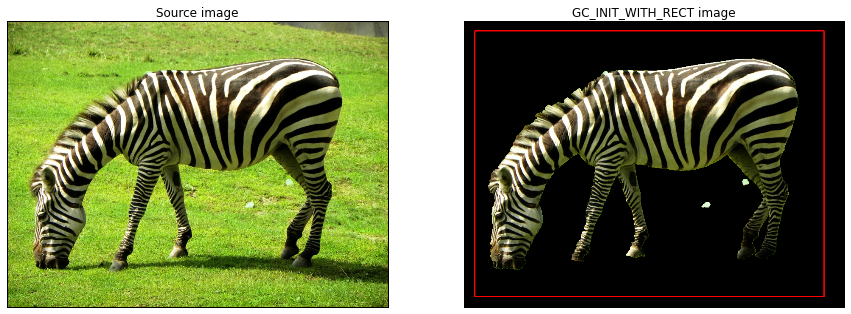

In [70]:
zebra_image = cv2.imread('zebra.jpg')
fig = plt.figure(figsize=(10, 5)) 
grab_cut_with_rect(zebra_image, (25, 25), (850, 650))

Видим, что для зебры сегментация сработала отлично. Это можно объяснить тем, что текстура зебры сильно отличается от фона изображения, она достаточно однородна: состоит всего из двух цветов, а также имеет четкие границы в отличие от утенка.